## Intro

While traditional Deep Learning relies on deterministic parameters optimized via gradient descent, Probabilistic AI explicitly represents uncertainty by modeling latent variables or parameters as random variables. Inference is performed by optimizing probabilistic objectives—most commonly the ELBO—using gradient-based optimization.

The goal is to infer quantities that are not directly observable, such as latent variables, future states, missing data, and different forms of uncertainty or risk present in the data or the environment.

***To be more intuitive:***

While traditional Deep Learning updates weights using the chain rule and gradient descent, Probabilistic AI updates weights through Bayesian inference, treating them as random variables rather than fixed values.

In theory, Probabilistic AI is based on computing the posterior distribution from a prior and a likelihood. In practice, however, the product of the prior and the likelihood produces highly irregular functions, which are usually impossible to solve analytically.

Because these functions are too complex to integrate directly, we introduce workarounds such as KL divergence and ELBO. Instead of computing the exact probability (the area under a complicated curve), we approximate the posterior with a simpler distribution that is easy to integrate, and optimize it to be as close as possible to the true posterior.

Finally, by the Law of Large Numbers, expectations computed under this approximated distribution can be estimated with arbitrarily high numerical accuracy. While this does not guarantee that the approximation equals the true posterior, it ensures that we measure the approximation itself very precisely, which is sufficient for practical inference.

## Gaussian Distribution

The distribution shows the probability density associated with each value on the x-axis. Gaussian (Normal) Distribution has the following formula:

$$
f(x) = \frac{1}{\sqrt{2\pi\sigma^2}} \exp \Big( -\frac{(x - \mu)^2}{2\sigma^2} \Big)
$$

Where:

* $\mu$ - mean  
* $\sigma$ - standard deviation  
* $\sigma^2$ - variance  

$\mu$ and $\sigma$ are parameters of Gaussian Distribution. For standard Gaussian distribution $\mu = 0$ and $\sigma = 1$, which can be described as:

$$
N(0,1):\quad f(x) = \frac{1}{\sqrt{2\pi}} \exp \Big( -\frac{x^2}{2} \Big)
$$


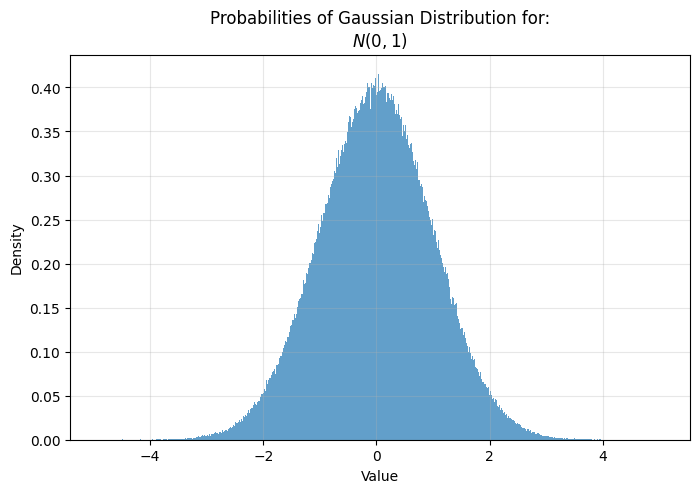

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

mu = 0
sigma = 1

X = mu + sigma * np.random.randn(1_000_000)

plt.figure(figsize = (8,5))

plt.hist(X, bins = 1_000, density = True, alpha = .7)
plt.title('Probabilities of Gaussian Distribution for:\n$N(0,1)$')
plt.grid(alpha=.3)
plt.xlabel('Value')
plt.ylabel('Density')
plt.show()

## Sampling with Reparametrization Trick

Sampling takes a single value from a given distribution. For example, if our distribution is $N(\mu=2.3, \sigma=2.1)$, then we take a single sample $x$ from the available values that belong to this distribution.

However, direct sampling from $N(\mu, \sigma)$ breaks differentiability, which makes learning impossible. To fix that, we always sample from a simple, fixed distribution such as $N(0,1)$, and then deterministically transform that sample into a sample from the desired distribution.

If we draw
$$
\epsilon \sim N(0,1),
$$

then a sample from our target distribution can be computed as:

$$
z = \mu + \sigma \cdot \epsilon.
$$

This transformation is differentiable with respect to $\mu$ and $\sigma$, which allows gradients to flow through the sampling process.

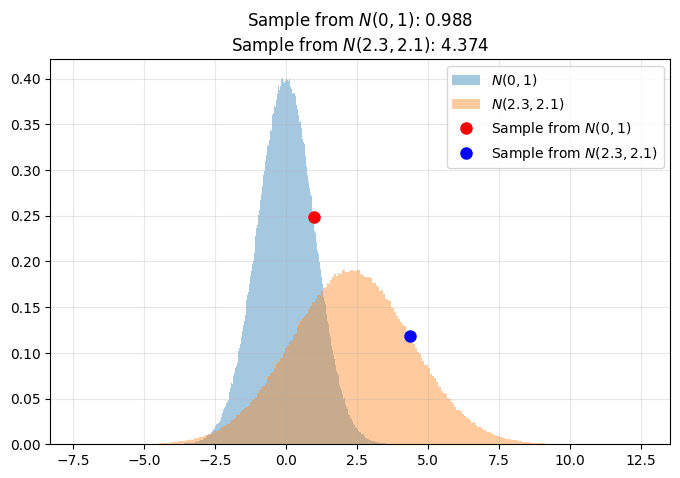

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

desired_mu = 2.3
desired_sigma = 2.1

# ----- Generate distributions -----
eps = np.random.randn(1_000_000)  # ε ~ N(0,1)

X = eps                          # N(0,1)
desired_X = desired_mu + desired_sigma * eps  # N(2.3, 2.1)

# ----- Single samples -----
random_sample = np.random.randn()                   # ε_single
desired_random_sample = desired_mu + desired_sigma * random_sample

# ----- Plot -----
plt.figure(figsize=(8,5))

# histograms
counts1, bins1, _ = plt.hist(X, bins=300, density=True, alpha=0.4, label="$N(0,1)$")
counts2, bins2, _ = plt.hist(desired_X, bins=300, density=True, alpha=0.4, label=f"$N({desired_mu},{desired_sigma})$")

# find densities for the dots
idx1 = np.digitize(random_sample, bins1) - 1
idx1 = np.clip(idx1, 0, len(counts1)-1)
y1 = counts1[idx1]

idx2 = np.digitize(desired_random_sample, bins2) - 1
idx2 = np.clip(idx2, 0, len(counts2)-1)
y2 = counts2[idx2]

# plot points
plt.plot(random_sample, y1, 'ro', markersize=8, label='Sample from $N(0,1)$')
plt.plot(desired_random_sample, y2, 'bo', markersize=8, label=f'Sample from $N({desired_mu},{desired_sigma})$')

plt.title(
    f"Sample from $N(0,1)$: {random_sample:.3f}\n"
    f"Sample from $N({desired_mu},{desired_sigma})$: {desired_random_sample:.3f}"
)
plt.grid(alpha=0.3)
plt.legend()
plt.show()

## Conditional Probability

Conditional probability answers the question: “How probable is A, given that B is true?”
It is the core mechanism behind Bayesian inference.

Traditional (prior) probability is defined before we observe anything new, so it is static — it does not react to changes in the world.
But in real systems, once we learn new information, our beliefs must update. Conditional probability gives us the mathematical tool to do that.

A simple example: before an exam, you may estimate a 70% chance of passing based on how much you studied. This is your prior.
After taking the exam — but before receiving the grade — you might realize it went worse than expected, so your estimated probability of passing drops to 45%. This updated belief is the posterior.

The exam performance is the conditioning event that changes your probability.

$$ P(A\mid B) = \frac{P(A\cap B)}{P(B)} $$

Where:

* $P(A\cap B)$ - Probability of $A$ and $B$ happens together
* $P(B)$ - Probability of $B$ happens

P(A)        = 0.1468  (14.68%)
P(B)        = 0.1453  (14.53%)
P(A ∩ B)    = 0.0305  (3.04%)
P(A | B)    = 0.2096


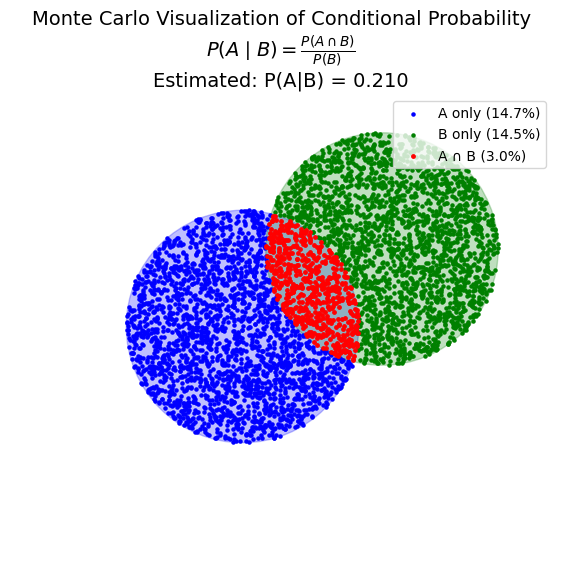

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# ---- Circle definitions ----
r = 1.5
A_center = np.array([0, 0])
B_center = np.array([1.8, 1.0])   # asymmetric small overlap

# ---- Sampling random points ----
N = 20000
points = np.random.uniform(-3, 4, (N, 2))

# ---- Check membership ----
dist_A = np.linalg.norm(points - A_center, axis=1)
dist_B = np.linalg.norm(points - B_center, axis=1)

in_A = dist_A < r
in_B = dist_B < r
in_intersection = in_A & in_B

# ---- Probabilities ----
P_A = in_A.mean()
P_B = in_B.mean()
P_A_and_B = in_intersection.mean()
P_A_given_B = P_A_and_B / P_B

percent_A = P_A * 100
percent_B = P_B * 100
percent_intersection = P_A_and_B * 100

print(f"P(A)        = {P_A:.4f}  ({percent_A:.2f}%)")
print(f"P(B)        = {P_B:.4f}  ({percent_B:.2f}%)")
print(f"P(A ∩ B)    = {P_A_and_B:.4f}  ({percent_intersection:.2f}%)")
print(f"P(A | B)    = {P_A_given_B:.4f}")

# ---- Visualization ----
fig, ax = plt.subplots(figsize=(7,7))

# draw circles
circle_A = plt.Circle(A_center, r, color='blue', alpha=0.25)
circle_B = plt.Circle(B_center, r, color='green', alpha=0.25)
ax.add_patch(circle_A)
ax.add_patch(circle_B)

# plot points
plt.scatter(points[in_A & ~in_B, 0], points[in_A & ~in_B, 1],
            s=5, c='blue', label=f"A only ({percent_A:.1f}%)")

plt.scatter(points[in_B & ~in_A, 0], points[in_B & ~in_A, 1],
            s=5, c='green', label=f"B only ({percent_B:.1f}%)")

plt.scatter(points[in_intersection, 0], points[in_intersection, 1],
            s=6, c='red', label=f"A ∩ B ({percent_intersection:.1f}%)")

plt.xlim(-3, 4)
plt.ylim(-3, 3)
plt.gca().set_aspect("equal")
plt.axis('off')

# ---- Title with equation ----
plt.title(
    "Monte Carlo Visualization of Conditional Probability\n"
    r"$P(A \mid B) = \frac{P(A \cap B)}{P(B)}$" +
    f"\nEstimated: P(A|B) = {P_A_given_B:.3f}",
    fontsize=14
)

plt.legend(loc='upper right')
plt.show()


## Bayes Rule

We need some tool to calculate $A \cap B$ in environments more complex than simple Venn diagrams.
Bayes Rule provides the likelihood identity:

$$ P(A\cap B) = P(B\mid A)\, P(A) $$

and from conditional probability:

$$ P(A\mid B) = \frac{P(B\mid A) P(A)}{P(B)}. $$

The purpose of this formula is to compute $P(A\mid B)$ when $P(B\mid A)$ is the quantity we can actually measure.
For example, if event $A$ is “a person has the flu” and event $B$ is “the person has a fever”, then:

$$
P(\text{flu} \mid \text{fever})
= \frac{P(\text{fever} \mid \text{flu}) \, P(\text{flu})}{P(\text{fever})}.
$$

Here, $P(B \mid A)$ or $P(\text{fever} \mid \text{flu})$ is the probability that a person has fever
given that they truly have the flu — this must be provided externally (e.g., medical statistics).
The whole idea of Bayes Rule is precisely to compute $P(\text{flu} \mid \text{fever})$ from $P(\text{fever} \mid \text{flu})$.


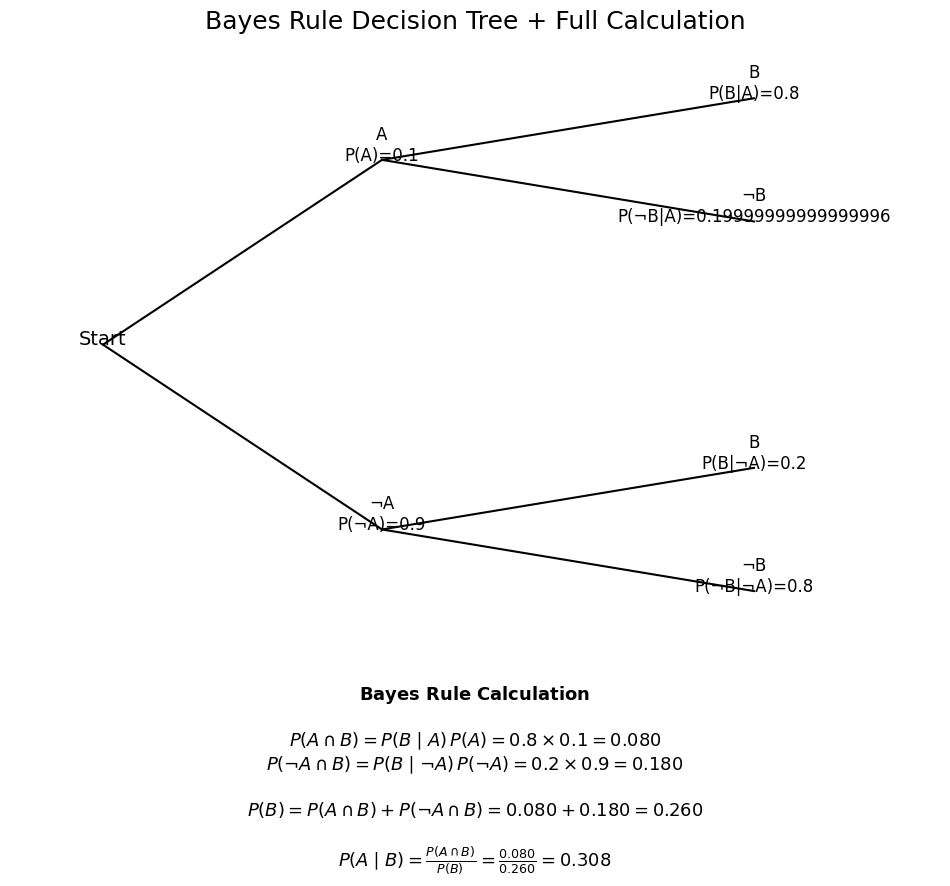

In [ ]:
import matplotlib.pyplot as plt

# Probabilities
P_A = 0.1
P_notA = 1 - P_A
P_B_given_A = 0.8
P_B_given_notA = 0.2

# Joint probabilities
P_A_and_B = P_A * P_B_given_A
P_notA_and_B = P_notA * P_B_given_notA

# Marginal P(B)
P_B = P_A_and_B + P_notA_and_B

# Posterior
P_A_given_B = P_A_and_B / P_B

fig, ax = plt.subplots(figsize=(12, 8))
ax.set_xlim(0, 10)
ax.set_ylim(0, 10)
ax.axis('off')

# Nodes
ax.text(1, 5, "Start", fontsize=14, ha='center')

ax.text(4, 8, f"A\nP(A)={P_A}", fontsize=12, ha='center')
ax.text(4, 2, f"¬A\nP(¬A)={P_notA}", fontsize=12, ha='center')

ax.text(8, 9, f"B\nP(B|A)={P_B_given_A}", fontsize=12, ha='center')
ax.text(8, 7, f"¬B\nP(¬B|A)={1-P_B_given_A}", fontsize=12, ha='center')

ax.text(8, 3, f"B\nP(B|¬A)={P_B_given_notA}", fontsize=12, ha='center')
ax.text(8, 1, f"¬B\nP(¬B|¬A)={1-P_B_given_notA}", fontsize=12, ha='center')

# Lines
ax.plot([1,4],[5,8], 'k-')
ax.plot([1,4],[5,2], 'k-')

ax.plot([4,8],[8,9], 'k-')
ax.plot([4,8],[8,7], 'k-')

ax.plot([4,8],[2,3], 'k-')
ax.plot([4,8],[2,1], 'k-')

# Title
plt.title("Bayes Rule Decision Tree + Full Calculation", fontsize=18)

# Calculation text
calc_text = (
    r"$\bf{Bayes\ Rule\ Calculation}$" "\n\n"
    rf"$P(A \cap B) = P(B \mid A)\,P(A) = {P_B_given_A} \times {P_A} = {P_A_and_B:.3f}$" "\n"
    rf"$P(\neg A \cap B) = P(B \mid \neg A)\,P(\neg A) = {P_B_given_notA} \times {P_notA} = {P_notA_and_B:.3f}$" "\n\n"
    rf"$P(B) = P(A \cap B) + P(\neg A \cap B) = {P_A_and_B:.3f} + {P_notA_and_B:.3f} = {P_B:.3f}$" "\n\n"
    rf"$P(A \mid B) = \frac{{P(A \cap B)}}{{P(B)}} = \frac{{{P_A_and_B:.3f}}}{{{P_B:.3f}}} = {P_A_given_B:.3f}$"
)

ax.text(5, -0.5, calc_text, fontsize=13, ha='center', va='top')

plt.show()

To sum up, Bayes Rule exists so that, having $P(B \mid A)$ and the prior $P(A)$,
we can compute the posterior $P(A \mid B)$. Without $P(B \mid A)$,
the posterior cannot be obtained.

## Integrals and Analytical Tracability

### Integral

In Probabilistic Theory

$$ \int p(z)\;dz = 1 $$

Integral is just an area under the function.

### Solvable Integral

$$ \int^{10}_5 2z\;dz = [z^2]^{10}_5 = 100 - 25 = 75 $$

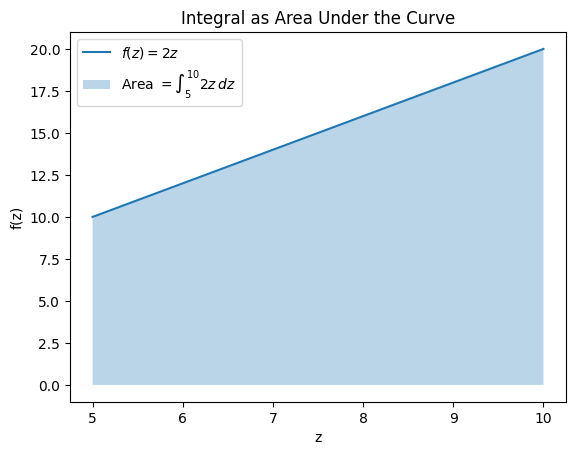

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def f(z):
    return 2*z

z = np.linspace(5, 10, 100)
y = f(z)

plt.plot(z, y, label=r'$f(z)=2z$')
plt.fill_between(z, y, alpha=0.3, label=r'Area $=\int_5^{10} 2z\,dz$')

plt.title(r'Integral as Area Under the Curve')
plt.xlabel('z')
plt.ylabel('f(z)')
plt.legend()

plt.show()

* 2z is a straght line
* integral is an area under this line from 0 to 1.

### Riemann Rectangle

We approximate integrals numerically using Riemann rectangles.
Instead of computing
$\int f(z),dz$,
we evaluate the function on a discrete grid and sum rectangular areas:

$$f(z_1)\Delta z + f(z_2)\Delta z + \dots$$

The step size
$\Delta z = z_{i+1} - z_i$
represents the width of each rectangle. As the grid becomes finer, the sum converges to the true value of the integral. This allows us to approximate expectations and KL divergence numerically when closed-form solutions are not available.

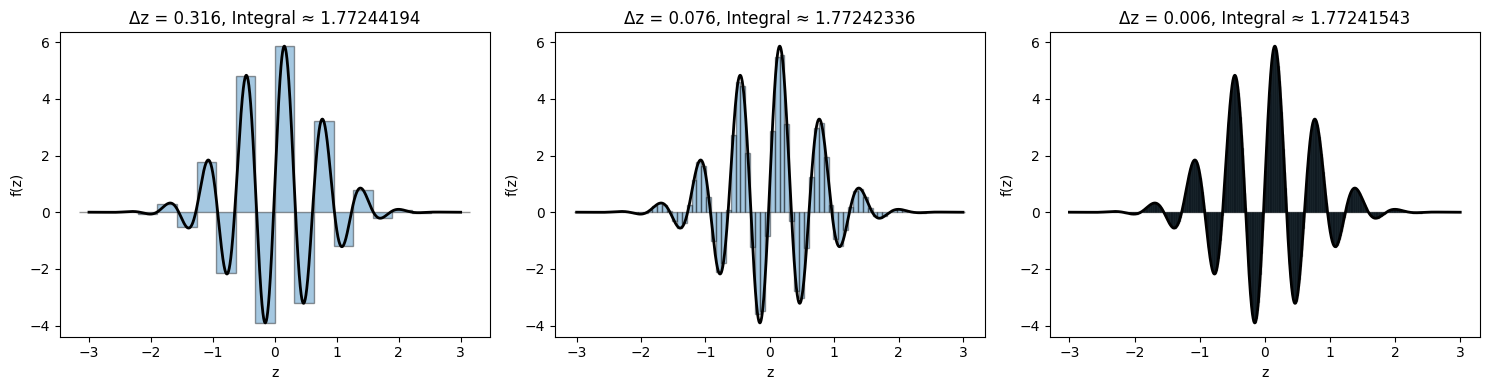

In [17]:
import numpy as np
import matplotlib.pyplot as plt

def f(z):
    return np.exp(-z**2) * (1 + 5*np.sin(10*z))

grids = [
    np.linspace(-3, 3, 20),    # bardzo grubo
    np.linspace(-3, 3, 80),    # średnio
    np.linspace(-3, 3, 1000),  # drobno
]

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for ax, z in zip(axes, grids):
    dz = z[1] - z[0]
    vals = f(z)
    integral = np.sum(vals * dz)

    # prawdziwa krzywa (referencja)
    z_fine = np.linspace(-3, 3, 5000)
    ax.plot(z_fine, f(z_fine), color='black', lw=2)

    # prostokąty Riemanna jako histogram
    ax.bar(z, vals, width=dz, alpha=0.4, edgecolor='k')

    ax.set_title(f"Δz = {dz:.3f}, Integral ≈ {integral:.8f}")
    ax.set_xlabel("z")
    ax.set_ylabel("f(z)")

plt.tight_layout()
plt.show()


As we can see integral is different for every example. The smaller Riemann's rectangles, the smaller error of integral.

### Solvable Integral with Bayesian Function

$$ \int p(y\;|\;z) \;p(z) \;dz$$
where:
$$ p(z) = x^2\ $$
$$ p(y|z) = 100 \cdot \exp{\frac{-(x-\mu)^2}{2 \cdot \sigma ^2}} $$

Bayesian functions $p(y|z)p(z)$ have 2 components:

$p(z)$ – prior, the probability of the latent variable $z$

$p(y|z)$ – likelihood, the probability of observing $y$ given $z$

$p(z)$ is a function of the latent variable $z$.
$p(y|z)$ is the probability of $y$ given a specific value of $z$.
Then $p(y|z)p(z)$ is simply the product of these two functions.

The integral $\int p(y|z)p(z)\;dz$ is the area under the product function.

<>:29: SyntaxWarning: invalid escape sequence '\i'
<>:29: SyntaxWarning: invalid escape sequence '\i'
/tmp/ipython-input-3374512927.py:29: SyntaxWarning: invalid escape sequence '\i'
  ax[1].plot(x, res, 'g-', label = '$\int p(z|y)\cdot p(z)$')


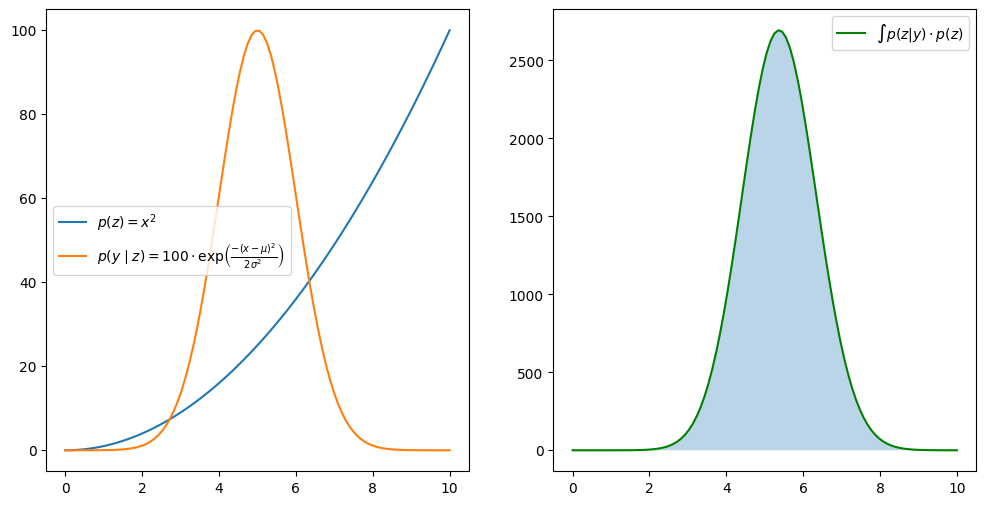

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def fz(x):
  return x**2

def fy(x):
    mu = 5
    sigma = 1
    return 100 *np.exp(-(x - mu)**2 / (2*sigma**2))

x = np.linspace(0, 10, 100)

fz_y = fz(x)
fy_y = fy(x)
res = fz_y * fy_y

fig, ax = plt.subplots(1,2,figsize = (12,6))

ax[0].plot(x, fz_y, label = '$p(z) = x^2 $')
ax[0].plot(
    x,
    fy_y,
    label=r'$p(y\mid z) = 100 \cdot \exp\!\left(\frac{-(x-\mu)^2}{2\sigma^2}\right)$'
)

ax[0].legend()

ax[1].plot(x, res, 'g-', label = '$\int p(z|y)\cdot p(z)$')
ax[1].fill_between(x, res, alpha = .3)
ax[1].legend()

plt.legend()
plt.show()

### Unsolvable Integral

Integral:

$$ \int exp(-x^2)\;dx $$

To solve integral means to find such $F(x)$ that $F'(x)=e^{-x^2} $ since an indefinite integral is defined as the inverse operation of differentiation.

Let

$$ u = x^2 $$

Now we need to calculate derrivative of $u$:

$$ u' = 2x $$

so

$$ du = 2x \;dx \rightarrow dx = \frac{du}{2x} $$

eventually we get:

$$ \int e^{-u}\frac{du}{2x} $$

At this point, the substitution does not eliminate the original variable
$x$.
The integral cannot be rewritten purely in terms of
$u$, which shows that the substitution fails and the integral does not admit a closed-form antiderivative.

To simplify: the integral is well-defined, but it does not admit a closed-form expression.
The only way to evaluate such an integral is through numerical (empirical) methods.
There is no elementary function that describes this integral.

<>:12: SyntaxWarning: invalid escape sequence '\i'
<>:12: SyntaxWarning: invalid escape sequence '\i'
/tmp/ipython-input-2549300899.py:12: SyntaxWarning: invalid escape sequence '\i'
  plt.fill_between(x, y, alpha = .5, label = '$\int \exp (-x^4)\;dx$')


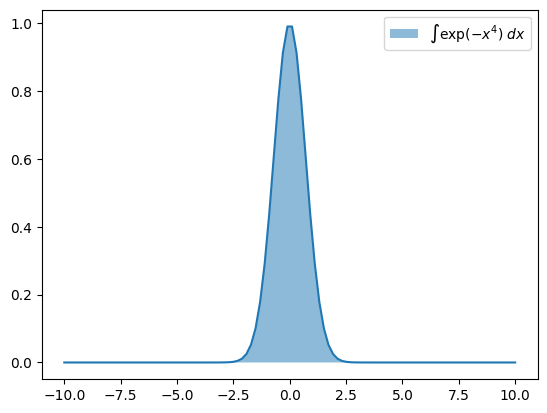

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

x = np.linspace(-10,10,100)

def f(x):
  return np.exp(-x**2)

y = f(x)

plt.plot(x, y)
plt.fill_between(x, y, alpha = .5, label = '$\int \exp (-x^2)\;dx$')
plt.legend()
plt.show()

From the plot, the integral of $\exp(-x^4)$ appears finite, as the function rapidly decays to values close to zero.
Although the tails are visually negligible, they still contribute a non-zero amount to the total area.
However, the reason this integral is not solvable in closed form is not the behavior of the tails, but the fact that no elementary function exists whose derivative equals $exp(-x^4)$. Therefore, the integral can be evaluated numerically but cannot be expressed analytically.

### Unsolvable Integral with Bayesian Function

Unsolvable Integral:

$$ Z = \int_{-\infty}^{\infty} \frac{1}{\sqrt{2\pi}} e^{-x^2/2} \frac{1}{1 + e^{-x}} dx $$

In Bayesian Integral we have prior and likelihood. Unsolvable Bayesian Integral can be assembled from prior integral which is solvable and likelihood integral which is solvable, but product integral of likelihood and piror is not solvable.

Prior:

$$  p(x) = N(x\,|\,\mu = 0,\sigma = 1) = \frac{1}{\sqrt{2\pi}} e^{-x^2/2} $$

Likelihood:

$$ p(y = 1 | x) = \sigma(x) = \frac{1}{1 + e^{-x}} $$


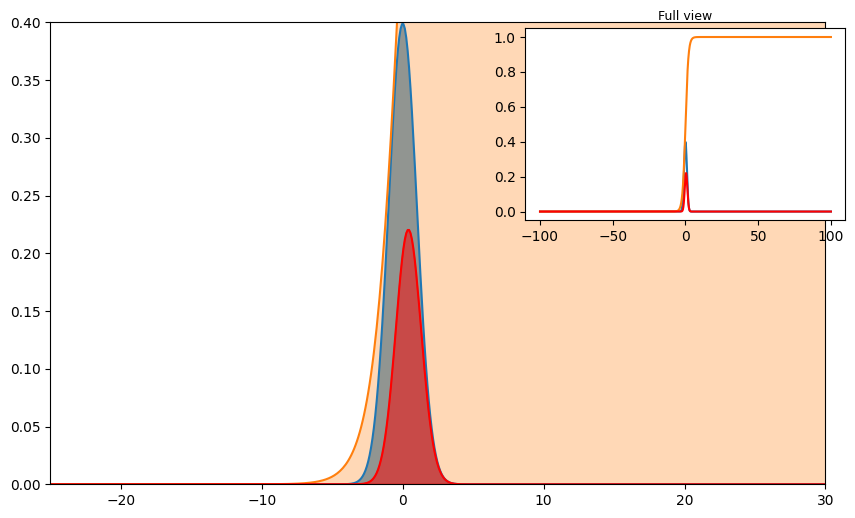

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

x = np.linspace(-100, 100, 2000)

def prior(x):
    return 1 / np.sqrt(2 * np.pi) * np.exp(-x**2 / 2)

def likelihood(x):
    return 1 / (1 + np.exp(-x))

prior_y = prior(x)
like_y = likelihood(x)
prod = prior_y * like_y

# === MAIN FIGURE ===
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(x, prior_y, label='prior (Gauss)')
ax.fill_between(x, prior_y, alpha=0.7)

ax.plot(x, like_y, label='likelihood (Sigmoid)')
ax.fill_between(x, like_y, alpha=0.3)

ax.plot(
    x,
    prod,
    '-r',
    label=r'product ($\int \frac{e^{-x^2/2}}{1+e^{-x}}\,dx$)'
)
ax.fill_between(x, prod, color='red', alpha=0.5)

# zoomed view
ax.set_xlim([-25, 30])
ax.set_ylim([0, 0.4])
ax.legend()

# === INSET (FACETIME VIEW) ===
inset_ax = fig.add_axes([0.6, 0.55, 0.32, 0.32])  # [left, bottom, width, height]

inset_ax.plot(x, prior_y)
inset_ax.plot(x, like_y)
inset_ax.plot(x, prod, '-r')

# NO xlim / ylim here → full range
inset_ax.set_title('Full view', fontsize=9)

plt.show()


Although the product appears compact in the plotted range, it is not a closed function. Both the Gaussian prior and the sigmoid likelihood are strictly positive for all real values of
𝑥
x, so their product also remains strictly positive and has infinitely long tails. These tails continue to contribute to the integral, even far from the center.

Prod:
$$ \int \frac{e^{-x^2/2}}{1 + e^{-x}} dx $$

In [47]:
import numpy as np

def prod(x):
    return np.exp(-x**2 / 2) / (1 + np.exp(-x))

xs = np.linspace(-40,40,1000)
ys = prod(xs)
ys[:50]

array([0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
       0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
       0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
       0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
       0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
       0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
       0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
       0.00000000e+000, 0.00000000e+000, 4.94065646e-324, 1.13635099e-322,
       2.49009086e-321, 5.38580961e-320, 1.15845054e-318, 2.47573578e-317,
       5.25710620e-316, 1.10918545e-314, 2.32528681e-313, 4.84355057e-312,
       1.00245779e-310, 2.06149983e-309, 4.21226279e-308, 8.55189894e-307,
       1.72514105e-305, 3.45781384e-304, 6.88642077e-303, 1.36270061e-301,
       2.67930584e-300, 5.23430568e-299])

As we can see above we have values that are not 0's from around -40 to around 40. That's exactly why we can't solve this integral by simple formula.

The prior and the likelihood are individually integrable, but their product

$$ \int \frac{e^{-x^2/2}}{1 + e^{-x}} dx $$

does not have a known closed-form solution. There is no formula that solves this integral exactly, so it can only be evaluated using numerical (empirical) methods.

## KL divergence

$$ KL(q || p) = E_q \Big[log \frac{q(z)}{p(z)}\Big] $$

* KL isn't symetrical: $ KL(q||p) \neq KL(p||q) $
* KL $\geq$ 0, is 0 only if $q = p$


KL divergence is a measure of simmilarity between 2 distributions. It's crucial for us in Variational Inference which we use to calculate integrals of functions that are unsolvable from theoretical perspective (can be solved only numerically). In VI we take simmilar distribution to our original but one for which we can define it's integral.

### Unsolvable Posterior

Let out original function $p(z)$ equals to:

$$ \int_{-\infty}^{\infty} e^{-x^2} log(1+e^z)\;dz $$

This function is not solvable.

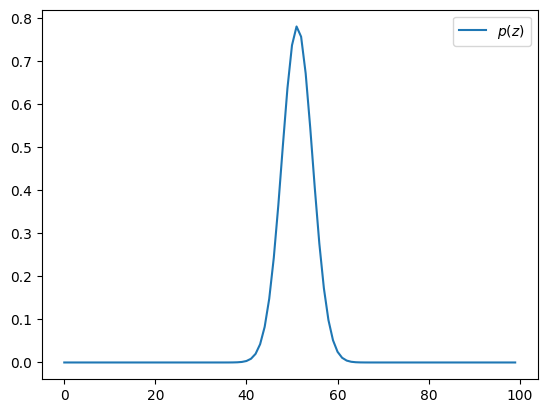

In [1]:
import matplotlib.pyplot as plt
import numpy as np

def p(z):
  return np.exp(-x**2)*np.log(1+np.exp(z))

x = np.linspace(-10,10,100)
y = p(x)

plt.plot(y, label = '$p(z)$')
plt.legend()
plt.show()

### Solvable Function

Although the true posterior $p(z)$ is not exactly Gaussian, its log-density is locally quadratic around the mode, which justifies using a Gaussian distribution as a first-order variational approximation.

$$ q(z) = \frac{1}{\sqrt{2\pi\sigma^2}}
\exp\!\left(
-\frac{(z-\mu)^2}{2\sigma^2}
\right)
 $$

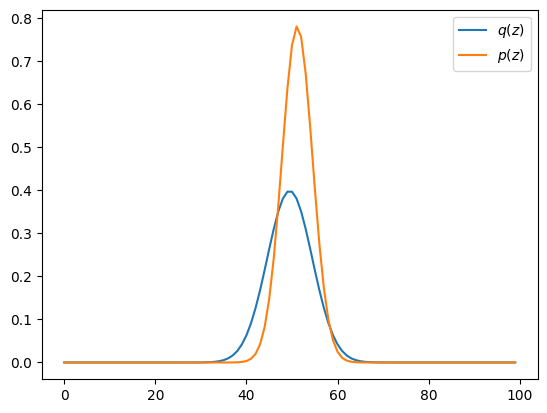

In [2]:
def q(z, mu, sigma):
    return (1 / np.sqrt(2 * np.pi * sigma**2)) * \
           np.exp(-0.5 * ((z - mu) / sigma)**2)

y_z = q(x, mu=0.0, sigma=1.0)

plt.plot(y_z, label = '$q(z)$')
plt.plot(y, label = '$p(z)$')
plt.legend()
plt.show()

As we can see, both distributions belong to the same family.
To quantify their similarity, we compute the Kullback–Leibler (KL) divergence:

$$ KL(q||p) = \int q(z) log\frac{q(z)}{p(z)} dz $$

### Formula

In [3]:
import sympy as sp

z = sp.symbols('z', real=True)

mu, sigma = sp.symbols('mu sigma', positive=True)

q = (1 / sp.sqrt(2*sp.pi*sigma**2)) * sp.exp(-(z - mu)**2 / (2*sigma**2))
p = sp.exp(-z**2) * sp.log(1 + sp.exp(z))  # nienormalizowane

KL = sp.integrate(q * sp.log(q / p), (z, -sp.oo, sp.oo))
KL

sqrt(2)*exp(-mu**2/(2*sigma**2))*Integral(-mu**2*exp(-z**2/(2*sigma**2))*exp(mu*z/sigma**2) + 2*mu*z*exp(-z**2/(2*sigma**2))*exp(mu*z/sigma**2) + 2*sigma**2*z**2*exp(-z**2/(2*sigma**2))*exp(mu*z/sigma**2) - 2*sigma**2*exp(-z**2/(2*sigma**2))*exp(mu*z/sigma**2)*log(sigma) - 2*sigma**2*exp(-z**2/(2*sigma**2))*exp(mu*z/sigma**2)*log(log(exp(z) + 1)) - sigma**2*exp(-z**2/(2*sigma**2))*exp(mu*z/sigma**2)*log(pi) - sigma**2*exp(-z**2/(2*sigma**2))*exp(mu*z/sigma**2)*log(2) - z**2*exp(-z**2/(2*sigma**2))*exp(mu*z/sigma**2), (z, -oo, oo))/(4*sqrt(pi)*sigma**3)

### Numerical

Note: Since $p(z)$ can be an arbitrary function, we must ensure that it integrates to $1$ in order to represent a valid probability distribution. A prerequisite for computing the KL divergence is that both $p(z)$ and $q(z)$ satisfy
$\int p(z),dz = 1$ and $\int q(z),dz = 1$.
The variational distribution $q(z)$ is chosen from a known distribution family and therefore already meets this requirement. As a result, only $p(z)$ needs to be normalized.

Note: As we know for each integral we need to specify width of the Riemann's traingle. We do this with $ dz = z[1] - z[0] $

In [8]:
import numpy as np

def p(z):
    return np.exp(-z**2) * np.log(1 + np.exp(z))

def q(z, mu, sigma):
    return (1 / np.sqrt(2 * np.pi * sigma**2)) * \
           np.exp(-0.5 * ((z - mu) / sigma)**2)

def kl_qp(x, q_vals, p_vals):
    dz = x[1] - x[0]
    return np.sum(q_vals * np.log(q_vals / p_vals)) * dz

z = np.linspace(-10, 10, 1000)
dz = z[1] - z[0]

p_vals = p(z)
p_vals = p_vals / np.sum(p_vals * dz)

q_vals = q(z, mu=0.0, sigma=1.0)

kl = kl_qp(z, q_vals, p_vals)
print("KL Divergence value KL(q||p) =",round(kl,4))

KL Divergence value KL(q||p) = 0.3094


### Interpretation

KL = $0.3$ is relatively small, which means that the approximation $q(z)$ is reasonably close to the true distribution $p(z)$, although it is not exact. This indicates that $q(z)$ captures the main structure of $p(z)$, but still introduces some approximation error.

At this stage, we deliberately chose a simple vanilla Gaussian $q(z)$ as a tractable approximation of the intractable distribution $p(z)$. This choice allows us to compute integrals and expectations, at the cost of introducing bias.

The next step is to rewrite the KL divergence $KL(q||p)$ using the ELBO, which removes the intractable normalization constant of $p(z)$.

Finally, Variational Inference optimizes the parameters of $q(z)$ by maximizing the ELBO, yielding the best possible approximation to $p(z)$ within the chosen variational family.

* $KL \approx 0$ → nearly perfect match

* $0 < KL < 0.5$ → good / reasonable approximation

* $0.5 < KL < 2$ → noticeable difference

* $KL \gg 1$ → very poor approximation

* $KL = \infty$ → completely incompatible distributions

## ELBO

Evidence Lower Bound (ELBO) is a function that we optimize in Probabilistic AI.
In the previous section, we introduced KL divergence, which measures the difference between two probability distributions. Our goal is to minimize the KL divergence so that the approximate distribution is as close as possible to the true one.

Since the KL divergence is not directly tractable, we optimize the ELBO instead, which is mathematically equivalent to minimizing the KL divergence.

ELBO can be viewed in a similar way to a loss function in traditional Deep Learning.
The key difference is that:

* in Deep Learning, we minimize a loss function,
* in Variational Inference, we maximize the ELBO.

$$ ELBO(q) = E_{q(z)}[log p(x|z)] - KL(q(z)||p(z)) $$

We just need to understand $log p(x|z)$. Since we decided to use Gaussian distribution as variational, therefore if

$$ p(x|z) = N(x\;|\; \mu, \sigma^2) = \frac{1}{\sqrt{2\pi\sigma^2}} \text{exp}\Big( -\frac{(x-\mu)^2}{2\sigma^2}
\Big)$$

then

$$ log\;p(x|z) = logN(x\;|\;\mu,\sigma^2) = -\frac{(x-\mu)^2}{2\sigma^2} - log(\sqrt{2\pi}\sigma) $$

Here $z$ are our values from $p(z)$ and $q(z)$, i.e. latent variables but $x$ represents data we observe.

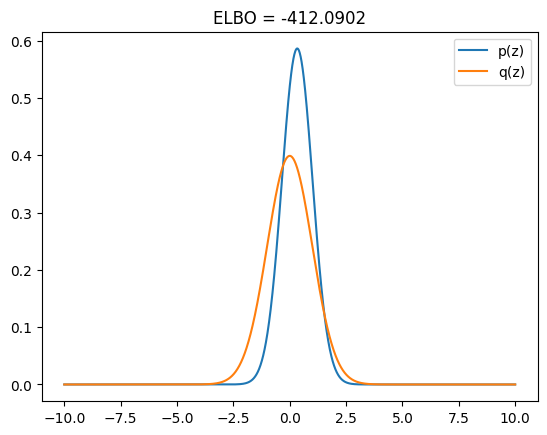

In [20]:
import numpy as np
import matplotlib.pyplot as plt

# normalized p(z)
def p(z):
    vals = np.exp(-z**2) * np.log(1 + np.exp(z))
    return vals / np.sum(vals * dz)

# q(z) = Gaussian
def q(z, mu, sigma):
    return (1 / np.sqrt(2 * np.pi * sigma**2)) * \
           np.exp(-0.5 * ((z - mu) / sigma)**2)

# KL(q || p)
def kl(z, q_vals, p_vals):
    dz = z[1] - z[0]
    return np.sum(q_vals * np.log(q_vals / p_vals)) * dz

def log_p_x_given_z(x, z, sigma_x):
    return - ((x - z)**2)/(2*sigma_x**2) - np.log(np.sqrt(2*np.pi)*sigma_x)

def expected_log_p_x_given_z(x, z, q_vals, sigma_x):
    dz = z[1] - z[0]
    total = 0.0
    for xi in x:
        total += np.sum(q_vals * log_p_x_given_z(xi, z, sigma_x) * dz)
    return total


# grid
z = np.linspace(-10, 10, 2000)
dz = z[1] - z[0]

# data
x = np.random.randn(100)

# distirbutions
p_vals = p(z)
q_vals = q(z, mu = 0.0, sigma = 1.0)

sigma_x = 0.5

def ELBO(x, z, q_vals, p_vals, sigma_x):
  return expected_log_p_x_given_z(x, z, q_vals, sigma_x) - kl(z, q_vals, p_vals)

elbo = ELBO(x, z, q_vals, p_vals, sigma_x)

plt.plot(z, p_vals, label='p(z)')
plt.plot(z, q_vals, label='q(z)')
plt.title(f"ELBO = {elbo:.4f}")
plt.legend()
plt.show()

The value
$ELBO \approx -412$
is very low, which means that the current variational distribution $q(z)$ explains the observed data $x$ poorly.

This happens because the expected log-likelihood term
$\mathbb{E}_{q(z)}[\log p(x \mid z)]$
is strongly negative for many data points, and the KL penalty further decreases the total value.

A negative ELBO is normal. What matters is not its absolute value, but whether ELBO increases during optimization, which indicates that $q(z)$ is becoming a better approximation of the true posterior.

This ELBO value should be treated as a single point on the ELBO objective function. Variational Inference consists of iteratively optimizing this objective by adjusting the parameters of $q(z)$ so that the ELBO increases and approaches its maximum.

## Variational Inference - Approximate Posterior

We use Variational Inference to iteratively adjust the parameters of the variational distribution $q(z)$ in order to maximize the ELBO with respect to the model defined by $p(z)$.

### Setup

Here is whole setup explained in previous sections.

In [30]:
import numpy as np
import matplotlib.pyplot as plt

# -----------------------------
# Grid over latent variable z
# -----------------------------
z = np.linspace(-10, 10, 2000)
dz = z[1] - z[0]

# -----------------------------
# Observed data x
# -----------------------------
np.random.seed(0)
x = np.random.randn(100)

# -----------------------------
# Prior p(z) (normalized)
# -----------------------------
def p(z):
    vals = np.exp(-z**2) * np.log(1 + np.exp(z))
    return vals / np.sum(vals * dz)

# -----------------------------
# Variational distribution q(z)
# -----------------------------
def q(z, mu, sigma):
    return (1 / np.sqrt(2 * np.pi * sigma**2)) * \
           np.exp(-0.5 * ((z - mu) / sigma)**2)

# -----------------------------
# KL(q || p) with stabilization
# -----------------------------
def kl(z, q_vals, p_vals):
    eps = 1e-12
    return np.sum(q_vals * np.log((q_vals + eps) / (p_vals + eps))) * dz

# -----------------------------
# log p(x | z)
# -----------------------------
def log_p_x_given_z(x, z, sigma_x):
    return -((x - z)**2) / (2 * sigma_x**2) - np.log(np.sqrt(2*np.pi) * sigma_x)

# -----------------------------
# Expected log-likelihood
# -----------------------------
def expected_log_likelihood(x, z, q_vals, sigma_x):
    total = 0.0
    for xi in x:
        total += np.sum(q_vals * log_p_x_given_z(xi, z, sigma_x) * dz)
    return total

# -----------------------------
# ELBO(mu, sigma)
# -----------------------------
def ELBO(x, z, mu, sigma, sigma_x):
    q_vals = q(z, mu, sigma)
    p_vals = p(z)
    return expected_log_likelihood(x, z, q_vals, sigma_x) - kl(z, q_vals, p_vals)


### VI Loop

In [40]:
# -----------------------------
# Variational Inference loop (with logs)
# -----------------------------
sigma_x = 0.5

mu = 2.0
rho = np.log(0.3)     # log(sigma)

lr_mu = 1e-3
lr_rho = 1e-3
eps = 1e-3

elbo_history = []
mu_history = []
sigma_history = []

for step in range(100):
    sigma = np.exp(rho)

    current_elbo = ELBO(x, z, mu, sigma, sigma_x)

    grad_mu = (
        ELBO(x, z, mu + eps, sigma, sigma_x)
        - ELBO(x, z, mu - eps, sigma, sigma_x)
    ) / (2 * eps)

    grad_rho = (
        ELBO(x, z, mu, np.exp(rho + eps), sigma_x)
        - ELBO(x, z, mu, np.exp(rho - eps), sigma_x)
    ) / (2 * eps)

    mu += lr_mu * grad_mu
    rho += lr_rho * grad_rho
    mu = np.clip(mu, -5, 5)

    elbo_history.append(current_elbo)
    mu_history.append(mu)
    sigma_history.append(np.exp(rho))

    # -------- LOGS --------
    if step % 5 == 0:
        print(
            f"step {step:03d} | "
            f"ELBO = {current_elbo:.2f} | "
            f"mu = {mu:.3f} | "
            f"sigma = {np.exp(rho):.3f} | "
            f"grad_mu = {grad_mu:.3e} | "
            f"grad_sigma = {grad_rho:.3e}"
        )


step 000 | ELBO = -1000.03 | mu = 1.220 | sigma = 0.290 | grad_mu = -7.797e+02 | grad_sigma = -3.519e+01
step 005 | ELBO = -244.00 | mu = 0.150 | sigma = 0.251 | grad_mu = -5.954e+01 | grad_sigma = -2.558e+01
step 010 | ELBO = -236.98 | mu = 0.068 | sigma = 0.224 | grad_mu = -4.547e+00 | grad_sigma = -2.008e+01
step 015 | ELBO = -235.26 | mu = 0.062 | sigma = 0.205 | grad_mu = -3.472e-01 | grad_sigma = -1.652e+01
step 020 | ELBO = -234.09 | mu = 0.061 | sigma = 0.190 | grad_mu = -2.648e-02 | grad_sigma = -1.401e+01
step 025 | ELBO = -233.22 | mu = 0.061 | sigma = 0.179 | grad_mu = -1.996e-03 | grad_sigma = -1.215e+01
step 030 | ELBO = -232.57 | mu = 0.061 | sigma = 0.169 | grad_mu = -1.322e-04 | grad_sigma = -1.072e+01
step 035 | ELBO = -232.05 | mu = 0.061 | sigma = 0.161 | grad_mu = 6.134e-06 | grad_sigma = -9.575e+00
step 040 | ELBO = -231.63 | mu = 0.061 | sigma = 0.154 | grad_mu = 1.375e-05 | grad_sigma = -8.647e+00
step 045 | ELBO = -231.28 | mu = 0.061 | sigma = 0.147 | grad_mu 

### Plots

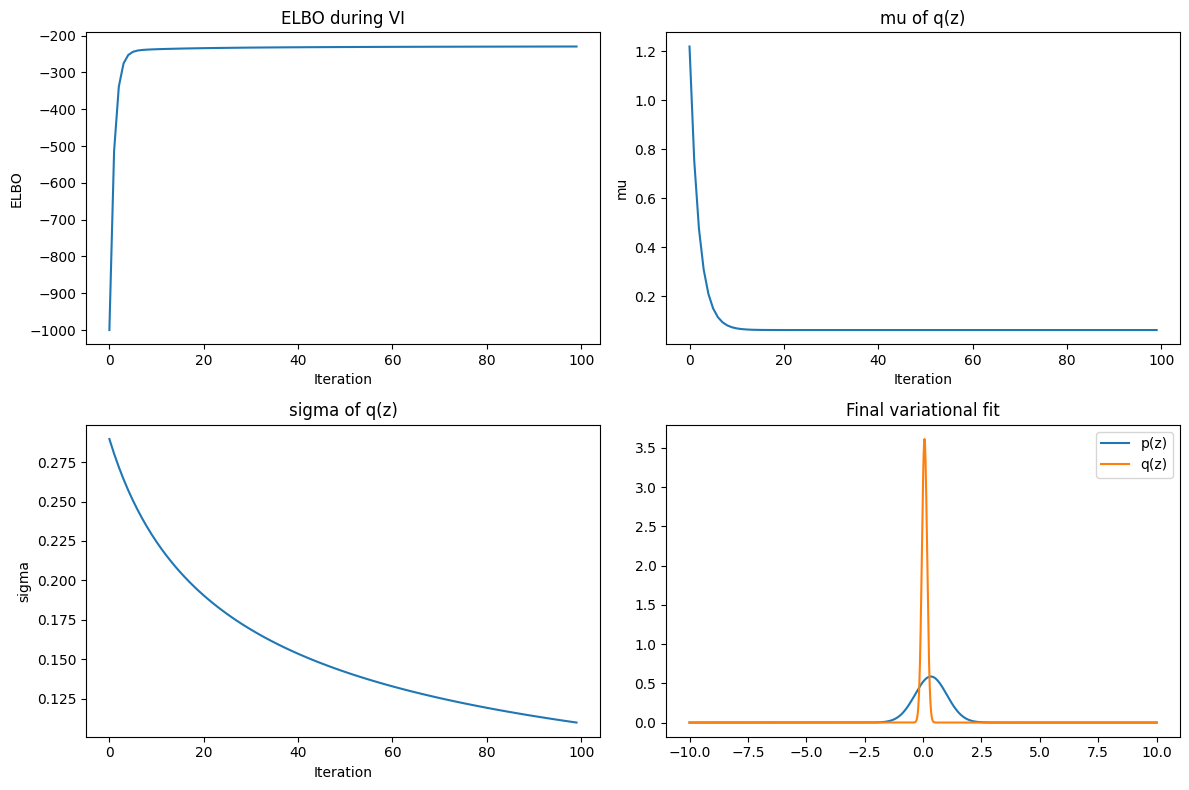

In [41]:
fig, ax = plt.subplots(2, 2, figsize=(12,8))

# ELBO
ax[0,0].plot(elbo_history)
ax[0,0].set_title("ELBO during VI")
ax[0,0].set_xlabel("Iteration")
ax[0,0].set_ylabel("ELBO")

# mu
ax[0,1].plot(mu_history)
ax[0,1].set_title("mu of q(z)")
ax[0,1].set_xlabel("Iteration")
ax[0,1].set_ylabel("mu")

# sigma
ax[1,0].plot(sigma_history)
ax[1,0].set_title("sigma of q(z)")
ax[1,0].set_xlabel("Iteration")
ax[1,0].set_ylabel("sigma")

# final distributions
ax[1,1].plot(z, p(z), label="p(z)")
ax[1,1].plot(z, q(z, mu, sigma), label="q(z)")
ax[1,1].set_title("Final variational fit")
ax[1,1].legend()

plt.tight_layout()
plt.show()

ELBO goes up very fast and then flattens
This means the optimization is working and quickly finds a good explanation of the data. After that, there is not much more to improve, so learning stabilizes.

The mean of q(z) moves quickly and then stops
The model rapidly finds where the latent variable should be centered to best explain the data. Once it finds that spot, there is no reason to move further.

The variance of q(z) keeps shrinking
This shows increasing confidence. The model is saying: “I am more and more certain that the latent variable has a very specific value.” This is expected when the data is informative.

Final plot: q(z) is much sharper than p(z)
This means the posterior belief is much more precise than the prior belief. The data strongly constrains the latent variable, so uncertainty collapses.

## PyTorch Implementation

In [43]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

torch.manual_seed(0)

# -----------------------------
# data
# -----------------------------
x = torch.randn(100)

# grid for plotting p(z)
z_grid = torch.linspace(-10, 10, 2000)

# -----------------------------
# prior p(z)
# -----------------------------
def log_p_z(z):
    return -z**2 + torch.log1p(torch.exp(z))

# normalize for plotting only
def p_z_plot(z):
    vals = torch.exp(log_p_z(z))
    return vals / torch.trapz(vals, z)

# -----------------------------
# variational parameters
# -----------------------------
mu = nn.Parameter(torch.tensor(2.0))
log_sigma = nn.Parameter(torch.tensor(-1.0))

# optimizer
optimizer = optim.Adam([mu, log_sigma], lr=1e-2)

sigma_x = 0.5

# -----------------------------
# training loop (VI)
# -----------------------------
elbo_history = []
mu_history = []
sigma_history = []

mu_init = mu.detach().clone()
sigma_init = sigma.detach().clone()

for step in range(300):
    optimizer.zero_grad()

    sigma = torch.exp(log_sigma)

    # sample z ~ q(z)
    eps = torch.randn(100)
    z = mu + sigma * eps

    # log q(z)
    log_qz = -0.5 * ((z - mu)/sigma)**2 - torch.log(sigma) - 0.5 * torch.log(torch.tensor(2*torch.pi))

    # log p(z)
    log_pz = log_p_z(z)

    # log p(x | z)
    log_px_given_z = -((x.unsqueeze(1) - z)**2)/(2*sigma_x**2) \
                     - torch.log(torch.tensor(sigma_x * (2*torch.pi)**0.5))
    log_px_given_z = log_px_given_z.mean(dim=0)

    # ELBO
    elbo = (log_px_given_z + log_pz - log_qz).mean()

    # maximize ELBO
    loss = -elbo
    loss.backward()
    optimizer.step()

    elbo_history.append(elbo.item())
    mu_history.append(mu.item())
    sigma_history.append(sigma.item())

    if step % 50 == 0:
        print(f"step {step:03d} | ELBO {elbo.item():.2f} | mu {mu.item():.3f} | sigma {sigma.item():.3f}")


step 000 | ELBO -12.52 | mu 1.990 | sigma 0.368
step 050 | ELBO -6.49 | mu 1.511 | sigma 0.412
step 100 | ELBO -4.39 | mu 1.102 | sigma 0.414
step 150 | ELBO -2.72 | mu 0.775 | sigma 0.409
step 200 | ELBO -2.21 | mu 0.532 | sigma 0.414
step 250 | ELBO -1.70 | mu 0.365 | sigma 0.410


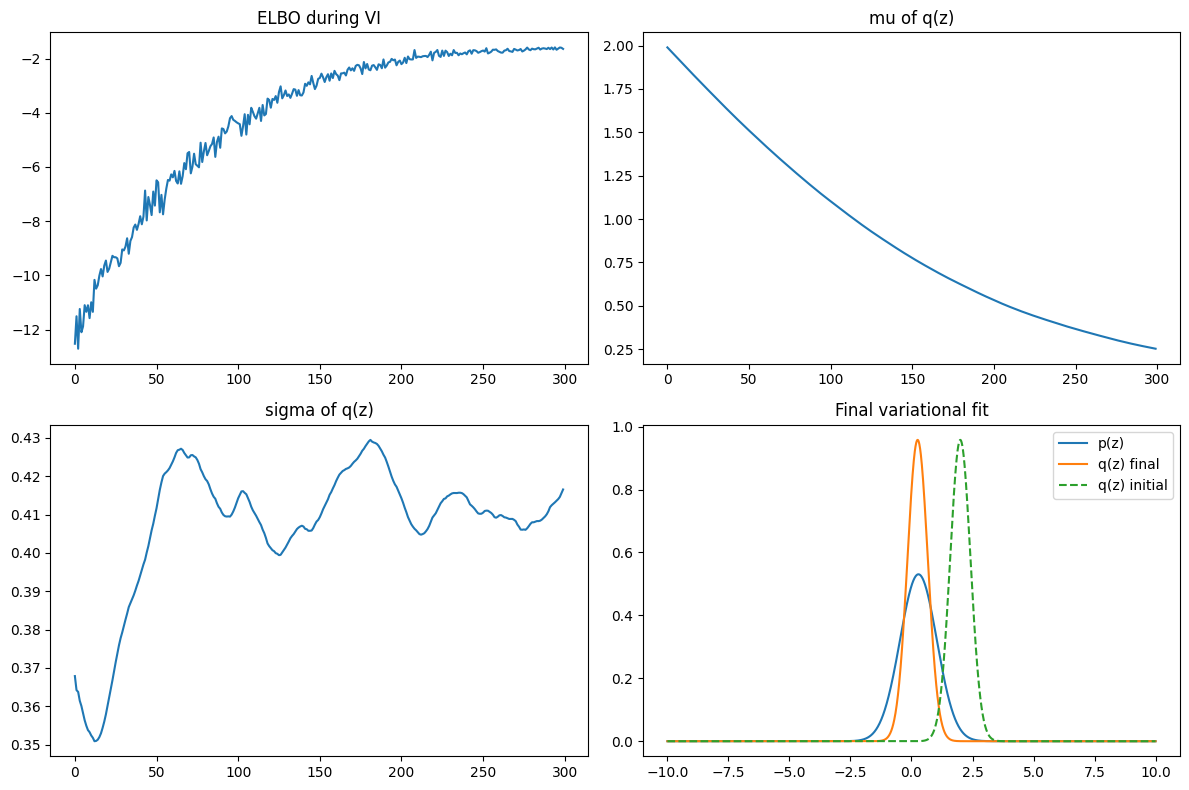

In [44]:
# -----------------------------
# plots
# -----------------------------
fig, ax = plt.subplots(2,2, figsize=(12,8))

ax[0,0].plot(elbo_history)
ax[0,0].set_title("ELBO during VI")

ax[0,1].plot(mu_history)
ax[0,1].set_title("mu of q(z)")

ax[1,0].plot(sigma_history)
ax[1,0].set_title("sigma of q(z)")

# final q(z)
q_final = torch.exp(
    -0.5 * ((z_grid - mu.detach()) / sigma.detach())**2
) / (sigma.detach() * torch.sqrt(torch.tensor(2 * torch.pi)))

# original q(z)
q_init = torch.exp(
    -0.5 * ((z_grid - mu_init) / sigma_init)**2
) / (sigma_init * torch.sqrt(torch.tensor(2 * torch.pi)))

ax[1,1].plot(z_grid, p_z_plot(z_grid).detach(), label="p(z)")
ax[1,1].plot(z_grid, q_final, label="q(z) final")
ax[1,1].plot(z_grid, q_init, "--", label="q(z) initial")

ax[1,1].legend()
ax[1,1].set_title("Final variational fit")

plt.tight_layout()
plt.show()

### Interpretation

The ELBO increases smoothly and stabilizes, which shows that the optimization is working correctly and consistently improving the variational approximation. Unlike the earlier hand-crafted VI, there are no unstable jumps or plateaus.

The mean of

q(z) moves gradually toward the region supported by the data and then converges. This indicates that the model is systematically refining its belief about the latent variable rather than oscillating or collapsing.

The variance of q(z) stabilizes instead of shrinking to zero. This is important: the model retains uncertainty instead of becoming overconfident. In probabilistic inference, preserving uncertainty is a sign of a well-behaved posterior.

The final q(z) is narrower than the prior
p(z) but still aligned with it. This is exactly what we expect: the data sharpens the belief while remaining consistent with the prior structure.

**Why this works better than the manual VI implementation?**

The PyTorch implementation uses automatic differentiation instead of numerical gradients, which removes noise and instability from the optimization process.

It relies on the reparameterization trick and sampling rather than grid-based integration, avoiding discretization bias and allowing gradients to flow correctly.

Adaptive optimization (Adam) provides stable and efficient updates, whereas fixed step sizes in manual VI often lead to divergence or premature collapse.

Overall, this implementation reflects how Variational Inference is performed in real probabilistic models, while the earlier version served mainly as a conceptual and numerical demonstration.